# **Demonstration - Rocket Twin**

## Imports

In [1]:
from rocket_twin.systems import Station, StationControllerFMU, RocketControllerFMU, StageControllerFMU
from rocket_twin.drivers import FuelingRocket, VerticalFlyingRocket, Mission
from rocket_twin.utils import run_sequences
from cosapp.utils import swap_system
from cosapp.drivers import RungeKutta, NonLinearSolver
from cosapp.recorders import DataFrameRecorder
import numpy as np
import matplotlib.pyplot as plt
from OCC.Display.SimpleGui import init_display

## Station creation

A station is the most basic system of the rocket-twin library. It contains a ground fuel tank, which is connected to a rocket (whose number of stages can be specified by the user) by a pipe. It also has a controller which controls the fuel flux between the tank and the rocket.

In [2]:
# Number of stages of the rocket
n_stages = 3

# Radius of the rocket
r = 1.

# System creation
sys = Station('sys', n_stages=n_stages)

# Adjust interval between fueling end and launch
sys.time_int = 10.

# Note that fueling and flying can be false at the same time: this happens between the fueling phase end and the launch time

## System architecture visualisation

In [3]:
sys

sys - Station

We can see that a rocket is composed by its stages and a controller (geom and dyn are physics classes and only perform computations). Each stage is composed by default by an engine, a tube, a fuel tank and also a controller. In addition, the first stage (the lowest) has a set of fins attached to it, while the last (the highest) has a nose.

## Tank parameters

Here we set the parameters for all the fuel tanks (for each stage and the ground). The tanks are assumed to be cylindrical (they have thick walls and a thick bottom), meaning we need to define:

1. The max fuel output rate
2. The internal radius
3. The external radius (same as the rocket radius)
4. The thickness of the bottom surface
5. The height
6. The densities for both the structure and the fuel
7. In the case of the stage tanks, their position

Each tank has a geometry module, which handles the structure and the fuel's shape and properties, and a fuel module, which handles the fuel mass at each instant. Besides their shape and properties (which are directly passed to the geometry module), each tank outputs their current fuel weight, their current fuel exit flow, and the maximum fuel capacity.

In [4]:
# Max fuel output rate

sys.g_tank.fuel.w_out_max = 1.
sys.rocket.stage_1.tank.fuel.w_out_max = 1.
sys.rocket.stage_2.tank.fuel.w_out_max = 1.
sys.rocket.stage_3.tank.fuel.w_out_max = 1.

In [5]:
# Internal radius

sys.g_tank.geom.r_int = 0.8
sys.rocket.stage_1.tank.geom.r_int = 0.8
sys.rocket.stage_2.tank.geom.r_int = 0.8
sys.rocket.stage_3.tank.geom.r_int = 0.8

In [6]:
# External radius

sys.g_tank.geom.r_ext = r
sys.rocket.stage_1.tank.geom.r_ext = r
sys.rocket.stage_2.tank.geom.r_ext = r
sys.rocket.stage_3.tank.geom.r_ext = r

In [7]:
# Thickness of bottom surface

sys.g_tank.geom.thickness = 0.2
sys.rocket.stage_1.tank.geom.thickness = 0.2
sys.rocket.stage_2.tank.geom.thickness = 0.2
sys.rocket.stage_3.tank.geom.thickness = 0.2

In [8]:
# Height

sys.g_tank.geom.height = 2.
sys.rocket.stage_1.tank.geom.height = 1.
sys.rocket.stage_2.tank.geom.height = 1.2
sys.rocket.stage_3.tank.geom.height = 1.4

In [9]:
# Fuel density

rho_fuel = 7.8125 / np.pi

sys.g_tank.geom.rho_fuel = rho_fuel
sys.rocket.stage_1.tank.geom.rho_fuel = rho_fuel
sys.rocket.stage_2.tank.geom.rho_fuel = rho_fuel
sys.rocket.stage_3.tank.geom.rho_fuel = rho_fuel

In [10]:
# Structure density

rho_struct = 1 / (0.56 * np.pi)

sys.g_tank.geom.rho_struct = rho_struct
sys.rocket.stage_1.tank.geom.rho_struct = rho_struct
sys.rocket.stage_2.tank.geom.rho_struct = rho_struct
sys.rocket.stage_3.tank.geom.rho_struct = rho_struct

In [11]:
# Stage tanks positions

sys.rocket.stage_1.tank.geom.pos = 0.
sys.rocket.stage_2.tank.geom.pos = 4.
sys.rocket.stage_3.tank.geom.pos = 8.

## Engine parameters

Here we set the parameters for each stage engine. All engines are assumed to be shaped like a truncated cone, meaning we need to define:

1. The base radius
2. The top radius
3. The height
4. The density of the structure
5. The position
6. The ISP (Specific impulse of the propellant)

Each engine has a geometry model, which handles the structure's shape and properties, and a performance model, which computes the thrust force achieved by the engine.

In [12]:
# Base radius

sys.rocket.stage_1.engine.geom.base_radius = 1.
sys.rocket.stage_2.engine.geom.base_radius = 1.
sys.rocket.stage_3.engine.geom.base_radius = 1.

In [13]:
# Top radius

sys.rocket.stage_1.engine.geom.top_radius = 0.5
sys.rocket.stage_2.engine.geom.top_radius = 0.5
sys.rocket.stage_3.engine.geom.top_radius = 0.5

In [14]:
# Height

sys.rocket.stage_1.engine.geom.height = 1.
sys.rocket.stage_2.engine.geom.height = 1.
sys.rocket.stage_3.engine.geom.height = 1.

In [15]:
# Density

sys.rocket.stage_1.engine.geom.rho = 12 / (7 * np.pi)
sys.rocket.stage_2.engine.geom.rho = 12 / (7 * np.pi)
sys.rocket.stage_3.engine.geom.rho = 12 / (7 * np.pi)

In [16]:
# Positions

sys.rocket.stage_1.engine.geom.pos = -1.2
sys.rocket.stage_2.engine.geom.pos = 2.8
sys.rocket.stage_3.engine.geom.pos = 6.8

In [17]:
# ISP

isp = 30.

sys.rocket.stage_1.engine.perfo.isp = isp
sys.rocket.stage_2.engine.perfo.isp = isp
sys.rocket.stage_3.engine.perfo.isp = isp

## Tube parameters

Here we set the parameters for the tube (the body) of each stage of the rocket. We need to define:

1. The radius (the same as the rocket radius)
2. The lenght
3. The density
4. The position

In [18]:
# Radius

sys.rocket.stage_1.tube.radius = r
sys.rocket.stage_2.tube.radius = r
sys.rocket.stage_3.tube.radius = r

In [19]:
# Length

sys.rocket.stage_1.tube.length = 3.
sys.rocket.stage_2.tube.length = 3.
sys.rocket.stage_3.tube.length = 3.

In [20]:
# Density

sys.rocket.stage_1.tube.rho = 0.2 / np.pi
sys.rocket.stage_2.tube.rho = 0.2 / np.pi
sys.rocket.stage_3.tube.rho = 0.2 / np.pi

In [21]:
# Positions

sys.rocket.stage_1.tube.pos = 1.
sys.rocket.stage_2.tube.pos = 5.
sys.rocket.stage_3.tube.pos = 9.

## Nose parameters

Here we set the parameters for the rocket's nose, attached to the highest stage. We need to define:

1. The radius (the same as the rocket radius)
2. The height
3. The density
4. The position

In [22]:
# Radius

sys.rocket.stage_3.nose.radius = r

In [23]:
# Height

sys.rocket.stage_3.nose.height = 1.

In [24]:
# Density

sys.rocket.stage_3.nose.rho = 3 / np.pi

In [25]:
# Position

sys.rocket.stage_3.nose.pos = 12.

## Wings parameters

Here we define the parameters for the set of wings attached to the lowest stage. We need to define:

1. The number of wings
2. The length of the edge attached to the rocket
3. The length of the free edge
4. The span (distance between the free edge and the rocket)
5. The thickness
6. The density
7. The radius (same as the rocket radius)
8. The position

In [26]:
# Number of wings

sys.rocket.stage_1.wings.n = 4

In [27]:
# Length of the attached edge

sys.rocket.stage_1.wings.l_in = 1.

In [28]:
# Length of the free edge

sys.rocket.stage_1.wings.l_out = 0.5

In [29]:
# Span

sys.rocket.stage_1.wings.width = 4 / 3

In [30]:
# Thickness

sys.rocket.stage_1.wings.th = 0.1

In [31]:
# Density

sys.rocket.stage_1.wings.rho = 10.

In [32]:
# Radius

sys.rocket.stage_1.wings.radius = r

In [33]:
# Position

sys.rocket.stage_1.wings.pos = 0.

## Choice of control mode

The control of the system can be done through either cosapp or .fmu files. In order to use the fmu control, either a .mo file (from OpenModelica) or an .fmu file should be passed to the system.

In [34]:
use_fmu = True

model_path = r"systems\control\station_controller.mo"
model_name = "station_controller"

model_path_r = r"systems\control\rocket_controller.mo"
model_name_r = "rocket_controller"

model_path_s = r"systems\control\stage_controller.mo"
model_name_s = "stage_controller"

if use_fmu:
    swap_system(sys.controller, StationControllerFMU("controller", model_path=model_path, model_name=model_name))
    swap_system(sys.rocket.controller, RocketControllerFMU("controller", model_path=model_path_r, model_name=model_name_r, n_stages=n_stages))
    for i in range(1, n_stages + 1):
        swap_system(sys.rocket[f"stage_{i}"].controller, StageControllerFMU("controller", model_path=model_path_s, model_name=model_name_s))

Connector source 'stage_1.outwards.weight_prop' has physical unit kg, but target 'controller.inwards.weight_prop_1' is dimensionless.
Connector source 'stage_1.outwards.weight_prop' has physical unit kg, but target 'controller.inwards.weight_prop_1' is dimensionless.
Connector source 'stage_2.outwards.weight_prop' has physical unit kg, but target 'controller.inwards.weight_prop_2' is dimensionless.
Connector source 'stage_2.outwards.weight_prop' has physical unit kg, but target 'controller.inwards.weight_prop_2' is dimensionless.
Connector source 'stage_3.outwards.weight_prop' has physical unit kg, but target 'controller.inwards.weight_prop_3' is dimensionless.
Connector source 'stage_3.outwards.weight_prop' has physical unit kg, but target 'controller.inwards.weight_prop_3' is dimensionless.


## Initial conditions

We consider that the rocket, while at the station, is at the origin of our coordinate system and has null speed. Therefore, the only initial conditions to be defined are the fuel masses in each tank and whether the rocket is mid-fueling or mid-flight, which we define below:

In [35]:
# Initial fuel mass

ground_tank_mass = 2.
stage1_tank_mass = 5.
stage2_tank_mass = 6.
stage3_tank_mass = 7.

# Phase

fuel = False
flight = True

## Simulation

The rocket simulation may be done through three different means:

1. By manually adding a time driver (EulerExplicit or RungeKutta) coupled with a NonLinearSolver, which can be imported from cosapp.drivers;
2. By using the rocket-specific drivers FuelingRocket (which simulates the fueling phase), VerticalFlyingRocket (which simulates the flight), or Mission (which simulates both), which can be imported from rocket_twin.drivers;
3. By using the command through sequences, importing the function run_sequences from rocket_twin.utils.

## Simulation by manually adding drivers

In [36]:
# Time interval and step

man_sim = True

dt = 1.
T = 50.

init = {"g_tank.fuel.weight_p" : ground_tank_mass,
        "rocket.stage_1.tank.fuel.weight_p" : stage1_tank_mass,
        "rocket.stage_2.tank.fuel.weight_p" : stage2_tank_mass,
        "rocket.stage_3.tank.fuel.weight_p" : stage3_tank_mass,
        "fueling" : fuel,
        "rocket.flying" : flight,
       }

sys.drivers.clear()
driver = sys.add_driver(RungeKutta(order=4, dt=dt))
driver.add_child(NonLinearSolver('solver'))
driver.time_interval = (0, T)
driver.set_scenario(init=init)

includes = ["rocket.a", "rocket.geom.weight", "rocket.weight_prop_1", 
            "rocket.weight_prop_2", "rocket.weight_prop_3", "g_tank.weight_prop"]

driver.add_recorder(DataFrameRecorder(includes=includes), period=1.0)

if man_sim:
    sys.run_drivers()
    data = driver.recorder.export_data()

## Simulation by rocket_twin drivers

### Fueling

In [37]:
fuel_sim = False

dt = 1.

init = {"g_tank.fuel.weight_p" : ground_tank_mass,
        "rocket.stage_1.tank.fuel.weight_p" : stage1_tank_mass,
        "rocket.stage_2.tank.fuel.weight_p" : stage2_tank_mass,
        "rocket.stage_3.tank.fuel.weight_p" : stage3_tank_mass,
        "fueling" : True,
        "rocket.flying" : False,
       }

stop = "rocket.flying == 1."

includes = ["rocket.a", "rocket.geom.weight", "rocket.weight_prop_1", 
            "rocket.weight_prop_2", "rocket.weight_prop_3", "g_tank.weight_prop"]

sys.drivers.clear()
sys.add_driver(FuelingRocket('fr', owner=sys, init=init, stop=stop, includes=includes, dt=dt))

if fuel_sim:
    sys.run_drivers()
    data = sys.drivers["fr"].data

### Flying

In [38]:
fly_sim = False

dt = 1.

init = {"g_tank.fuel.weight_p" : ground_tank_mass,
        "rocket.stage_1.tank.fuel.weight_p" : stage1_tank_mass,
        "rocket.stage_2.tank.fuel.weight_p" : stage2_tank_mass,
        "rocket.stage_3.tank.fuel.weight_p" : stage3_tank_mass,
        "rocket.controller.is_on_1" : True,
        "fueling" : False,
        "rocket.flying" : True,
       }

stop = f"rocket.stage_{n_stages}.tank.weight_prop <= 0.15"

includes = ["rocket.a", "rocket.geom.weight", "rocket.weight_prop_1", 
            "rocket.weight_prop_2", "rocket.weight_prop_3", "g_tank.weight_prop"]

sys.drivers.clear()
sys.add_driver(VerticalFlyingRocket('vfr', owner=sys, init=init, stop=stop, includes=includes, dt=dt))

if fly_sim:
    sys.run_drivers()
    data = sys.drivers["vfr"].data

### Mission (fueling + flying) (bug avec le temps)

In [39]:
mis_sim = False

dt = 1.

init = {"g_tank.fuel.weight_p" : ground_tank_mass,
        "rocket.stage_1.tank.fuel.weight_p" : stage1_tank_mass,
        "rocket.stage_2.tank.fuel.weight_p" : stage2_tank_mass,
        "rocket.stage_3.tank.fuel.weight_p" : stage3_tank_mass,
        "fueling" : True,
        "rocket.flying" : False,
       }

stop = f"rocket.stage_{n_stages}.tank.weight_prop <= 0"

includes = ["rocket.a", "rocket.geom.weight", "rocket.weight_prop_1", 
            "rocket.weight_prop_2", "rocket.weight_prop_3", "g_tank.weight_prop"]

sys.drivers.clear()
sys.add_driver(Mission('mission', owner=sys, init=init, stop=stop, includes=includes, dt=dt))

if mis_sim:
    sys.run_drivers()
    data = sys.drivers["mission"].data

## Simulation by cosapp sequences

In [40]:
seq_sim = False

#Stop conditions
stop_fuel = f"rocket.stage_{n_stages}.tank.weight_prop == rocket.stage_{n_stages}.tank.weight_max"
stop_fly = f"rocket.stage_{n_stages}.tank.weight_prop == 0."

#Sequences
seq_init = [{"name" : "start", "init" : {"g_tank.fuel.weight_p" : 20.}, "type" : "static"}] 
seq_fuel = [{"name" : "fuel", "type" : "transient", "dt" : 1.0, "stop" : stop_fuel}]
seq_fly = [{"name" : "flight", "type" : "transient", "dt" : 1.0, "stop" : stop_fly}]

seq = [seq_init[0], seq_fuel[0], seq_fly[0]]

includes = ["rocket.a", "rocket.geom.weight", "rocket.weight_prop_1", 
            "rocket.weight_prop_2", "rocket.weight_prop_3", "g_tank.weight_prop"]

if seq_sim:
    run_sequences(sys, seq, includes)
    data = sys.drivers['rk'].recorder.export_data()

## Data processing

In [41]:
acel = np.asarray(data["rocket.a"])
mass = np.asarray(data["rocket.geom.weight"])
time = np.asarray(data["time"])

fuel1 = np.asarray(data["rocket.weight_prop_1"])
fuel2 = np.asarray(data["rocket.weight_prop_2"])
fuel3 = np.asarray(data["rocket.weight_prop_3"])
fuelg = np.asarray(data["g_tank.weight_prop"])

## Results

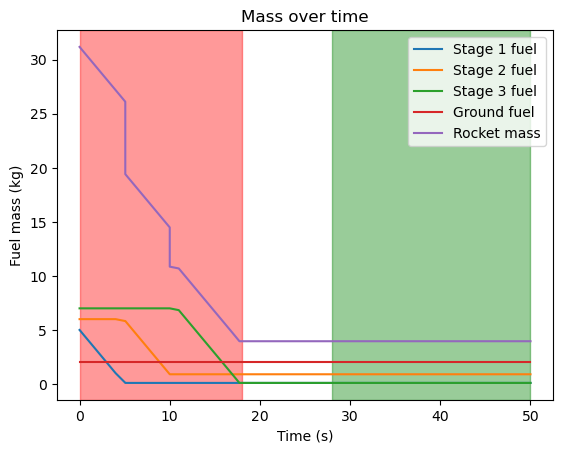

In [42]:
plt.plot(time, fuel1, label="Stage 1 fuel")
plt.plot(time, fuel2, label="Stage 2 fuel")
plt.plot(time, fuel3, label="Stage 3 fuel")
plt.plot(time, fuelg, label="Ground fuel")
plt.plot(time, mass, label="Rocket mass")
plt.axvspan(0, 18, color="RED", alpha=0.4)
plt.axvspan(28, 50, color="GREEN", alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Fuel mass (kg)")
plt.title("Mass over time")
plt.legend()
plt.show()

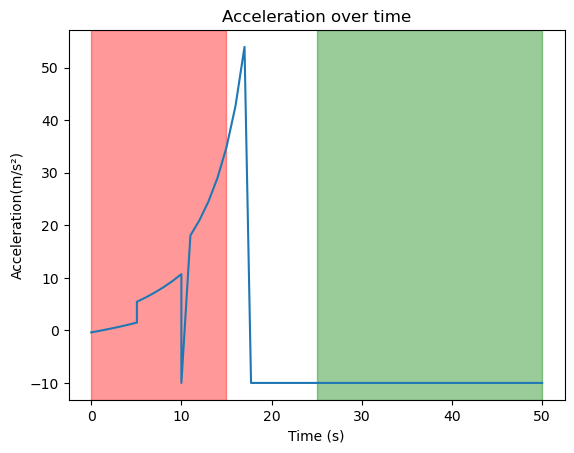

In [43]:
plt.plot(time, acel, label="Rocket Acceleration")
plt.axvspan(0, 15, color="RED", alpha=0.4)
plt.axvspan(25, 50, color="GREEN", alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration(m/s²)")
plt.title("Acceleration over time")
plt.show()

## System Visualisation

In [44]:
view = False

if view:
    shapes = []
    sys.run_once()
        
    def dfs(sys):
        try:
            shapes.append(sys.shape)
        except Exception:
            pass
        for child in sys.children:
            dfs(sys[child])
            
    dfs(sys.rocket)
    display, start_display, add_menu, add_function_to_menu = init_display()
    for shape in shapes:
        if shape is not None:
            display.DisplayShape(shape)
    start_display()